# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [36]:
# Check for GPU
!nvidia-smi

Mon Jun 17 18:54:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0              33W /  70W |    181MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [37]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.3.0+cu121


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [38]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)
print("Ready")

data/pizza_steak_sushi directory exists.
Unzipping pizza, steak, sushi data...
Ready


In [39]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


In [40]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Selected image path: data/pizza_steak_sushi/train/sushi/307738.jpg
Image class: sushi
Image dimensions: 512 x 382


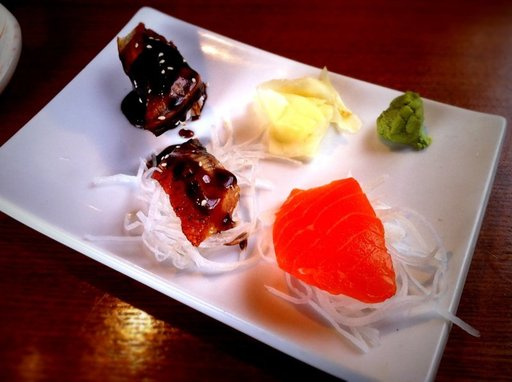

In [41]:
import random
from PIL import Image

dataset_directory = Path("data/pizza_steak_sushi")

all_image_files = list(dataset_directory.glob("*/*/*.jpg"))
selected_image_path = random.choice(all_image_files)
print(f"Selected image path: {selected_image_path}")
image_class_name = selected_image_path.parent.stem
loaded_image = Image.open(selected_image_path)
print(f"Image class: {image_class_name}")
print(f"Image dimensions: {loaded_image.width} x {loaded_image.height}")
loaded_image

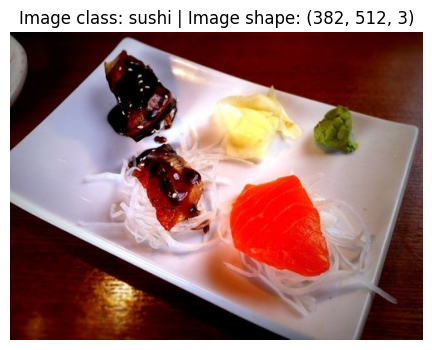

In [42]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(loaded_image)
plt.figure(figsize=(6, 4))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class_name} | Image shape: {img_as_array.shape}")
plt.axis("off");

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [43]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random

In [44]:
transform = transforms.Compose([
  transforms.Resize(size=(64, 64)),
  transforms.ToTensor()
])

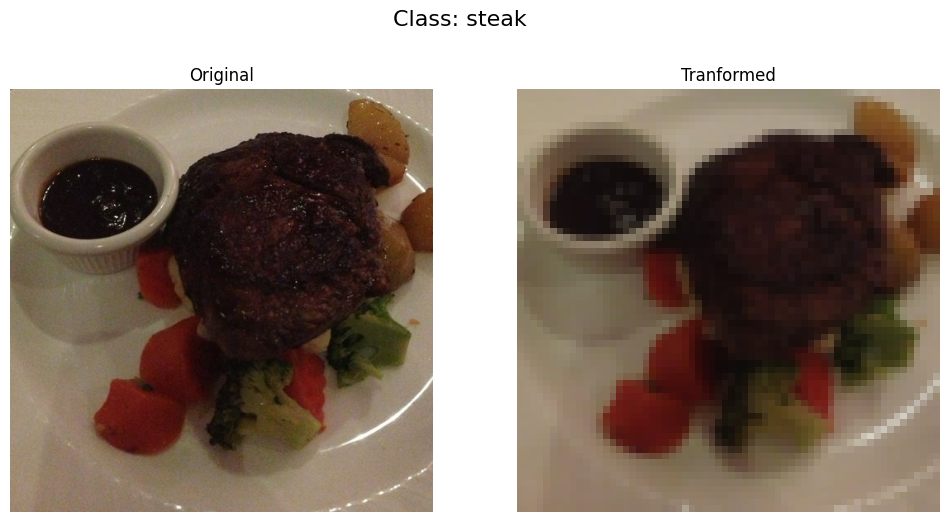

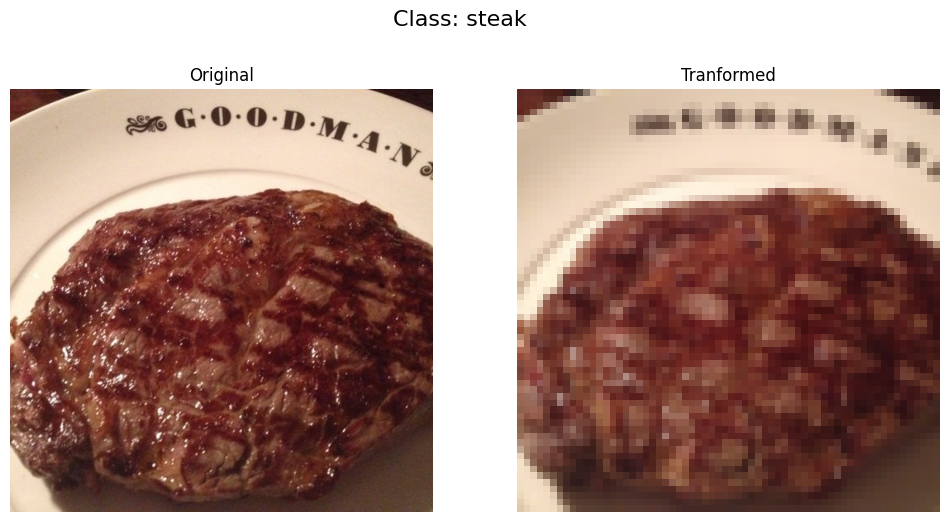

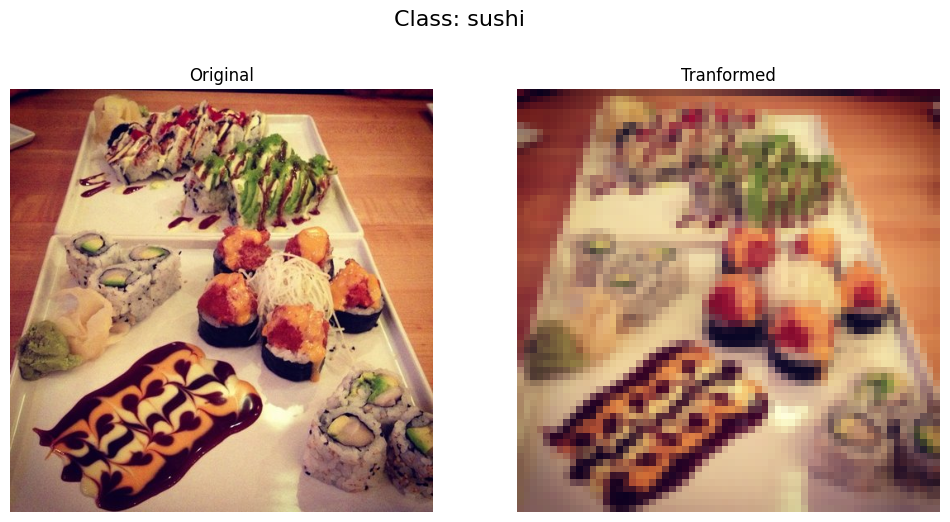

In [45]:
def display_transformed_images(paths, apply_transform, count=3, random_seed=42):
    random.seed(random_seed)
    chosen_image_paths = random.sample(paths, k=count)

    for img_path in chosen_image_paths:
        with Image.open(img_path) as image:
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))

            axes[0].imshow(image)
            axes[0].set_title("Original")
            axes[0].axis('off')

            transformed_img = apply_transform(image).permute(1, 2, 0)
            axes[1].imshow(transformed_img)
            axes[1].set_title(f"Tranformed")
            axes[1].axis('off')

            fig.suptitle(f"Class: {img_path.parent.stem}", fontsize=16)
            plt.show()

display_transformed_images(all_image_files, transform, count=3)


### Load image data using `ImageFolder`

In [46]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [47]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [48]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [49]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [50]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=2,shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=2, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79b8492fd780>,
 <torch.utils.data.dataloader.DataLoader at 0x79b8492fdb70>)

In [51]:
img, label = next(iter(train_dataloader))

In [52]:
img.shape

torch.Size([2, 3, 64, 64])

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [53]:
import torch
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape))

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [54]:
model_0 = TinyVGG(input_shape = 3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

## 4. Create training and testing functions for `model_0`.

In [55]:
import numpy as np
def train(model, opt, loss_fn, epochs, history, device, tr_loader, test_loader):
    for epoch in range(epochs):
        print('----- Epoch %d/%d -----' % (epoch+1, epochs))
        avg_loss_tr = 0
        model.train()
        for X_batch, Y_batch in tr_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            opt.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()
            opt.step()
            avg_loss_tr += loss / len(tr_loader)
        #del X_batch, Y_batch, Y_pred_0, Y_pred_1, Y_pred_2, Y_pred_3
        #gc.collect()
        history['train loss'].append(avg_loss_tr.detach().cpu().numpy())
        print('train loss: %f \n' % avg_loss_tr, end='  ')
        torch.cuda.empty_cache()
        model.eval()
        with torch.no_grad():
            avg_loss_val = 0
            for X_batch, Y_batch in test_loader:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)
                Y_pred = model(X_batch)
                loss_val = loss_fn(Y_pred, Y_batch)
                avg_loss_val += loss_val / len(test_loader)
            #del X_batch, Y_batch, Y_pred_0, Y_pred_1, Y_pred_2, Y_pred_3
            #gc.collect()
        history['val loss'].append(avg_loss_val.detach().cpu().numpy())
        print('val loss: %f \n' % avg_loss_val)
        weights_filename = f'resnet_50_weights_p1_epoch{epoch+1}.pth'
        torch.save(model.state_dict(), weights_filename)
        #print("--- %i seconds ---" % (time.time() - start_time))


## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [56]:
%%time
# Train for 5 epochs
device_gpu = torch.device('cuda')
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model_0.parameters(), lr=1e-3)
model_0.to(device_gpu)
max_epochs = 5
history = {'train loss':[], 'val loss':[]}
train(model_0, optim, loss_fn, 5, history, device_gpu, train_dataloader, test_dataloader)

----- Epoch 1/5 -----
train loss: 1.107222 
  val loss: 1.097161 

----- Epoch 2/5 -----
train loss: 1.070266 
  val loss: 1.126861 

----- Epoch 3/5 -----
train loss: 0.966691 
  val loss: 1.024332 

----- Epoch 4/5 -----
train loss: 0.903516 
  val loss: 1.016660 

----- Epoch 5/5 -----
train loss: 0.833913 
  val loss: 1.052397 

CPU times: user 6.09 s, sys: 109 ms, total: 6.2 s
Wall time: 6.26 s


In [57]:
%%time
# Train for 20 epochs
model_1 = TinyVGG(input_shape = 3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
device_gpu = torch.device('cuda')
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model_1.parameters(), lr=1e-3)
model_1.to(device_gpu)
max_epochs = 20
history = {'train loss':[], 'val loss':[]}
train(model_1, optim, loss_fn, max_epochs, history, device_gpu, train_dataloader, test_dataloader)

----- Epoch 1/20 -----
train loss: 1.110661 
  val loss: 1.092466 

----- Epoch 2/20 -----
train loss: 1.038259 
  val loss: 1.056589 

----- Epoch 3/20 -----
train loss: 0.939915 
  val loss: 0.990509 

----- Epoch 4/20 -----
train loss: 0.877932 
  val loss: 1.143040 

----- Epoch 5/20 -----
train loss: 0.820777 
  val loss: 1.063293 

----- Epoch 6/20 -----
train loss: 0.777873 
  val loss: 1.112274 

----- Epoch 7/20 -----
train loss: 0.736266 
  val loss: 1.045349 

----- Epoch 8/20 -----
train loss: 0.689959 
  val loss: 1.059881 

----- Epoch 9/20 -----
train loss: 0.611971 
  val loss: 1.149680 

----- Epoch 10/20 -----
train loss: 0.488019 
  val loss: 1.276505 

----- Epoch 11/20 -----
train loss: 0.487628 
  val loss: 1.500019 

----- Epoch 12/20 -----
train loss: 0.277624 
  val loss: 2.364344 

----- Epoch 13/20 -----
train loss: 0.215297 
  val loss: 2.264871 

----- Epoch 14/20 -----
train loss: 0.134132 
  val loss: 2.397057 

----- Epoch 15/20 -----
train loss: 0.09581

In [58]:
%%time
# Train for 50 epochs
model_2 = TinyVGG(input_shape = 3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
device_gpu = torch.device('cuda')
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model_2.parameters(), lr=1e-3)
model_2.to(device_gpu)
max_epochs = 50
history = {'train loss':[], 'val loss':[]}
train(model_2, optim, loss_fn, max_epochs, history, device_gpu, train_dataloader, test_dataloader)

----- Epoch 1/50 -----
train loss: 1.102569 
  val loss: 1.101905 

----- Epoch 2/50 -----
train loss: 1.099278 
  val loss: 1.100900 

----- Epoch 3/50 -----
train loss: 1.098703 
  val loss: 1.100815 

----- Epoch 4/50 -----
train loss: 1.100461 
  val loss: 1.103108 

----- Epoch 5/50 -----
train loss: 1.052606 
  val loss: 1.072340 

----- Epoch 6/50 -----
train loss: 0.960392 
  val loss: 1.015717 

----- Epoch 7/50 -----
train loss: 0.864374 
  val loss: 0.969764 

----- Epoch 8/50 -----
train loss: 0.827434 
  val loss: 0.990263 

----- Epoch 9/50 -----
train loss: 0.737871 
  val loss: 1.034205 

----- Epoch 10/50 -----
train loss: 0.689295 
  val loss: 1.050628 

----- Epoch 11/50 -----
train loss: 0.605068 
  val loss: 1.104505 

----- Epoch 12/50 -----
train loss: 0.496181 
  val loss: 1.199697 

----- Epoch 13/50 -----
train loss: 0.358450 
  val loss: 1.442548 

----- Epoch 14/50 -----
train loss: 0.257651 
  val loss: 1.949308 

----- Epoch 15/50 -----
train loss: 0.18476

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [59]:
model_3 = TinyVGG(input_shape=3,
                  hidden_units=20,
                  output_shape=len(class_names)).to(device)
device_gpu = torch.device('cuda')
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model_3.parameters(), lr=1e-3)
model_3.to(device_gpu)
max_epochs = 20
history = {'train loss':[], 'val loss':[]}
train(model_3, optim, loss_fn, max_epochs, history, device_gpu, train_dataloader, test_dataloader)


----- Epoch 1/20 -----
train loss: 1.061616 
  val loss: 1.032780 

----- Epoch 2/20 -----
train loss: 0.975033 
  val loss: 0.991671 

----- Epoch 3/20 -----
train loss: 0.862254 
  val loss: 1.041119 

----- Epoch 4/20 -----
train loss: 0.803100 
  val loss: 0.960661 

----- Epoch 5/20 -----
train loss: 0.771218 
  val loss: 1.048885 

----- Epoch 6/20 -----
train loss: 0.732231 
  val loss: 1.117961 

----- Epoch 7/20 -----
train loss: 0.665468 
  val loss: 1.172506 

----- Epoch 8/20 -----
train loss: 0.562664 
  val loss: 1.423372 

----- Epoch 9/20 -----
train loss: 0.417350 
  val loss: 1.554134 

----- Epoch 10/20 -----
train loss: 0.304911 
  val loss: 1.946725 

----- Epoch 11/20 -----
train loss: 0.336620 
  val loss: 1.639272 

----- Epoch 12/20 -----
train loss: 0.214367 
  val loss: 2.405995 

----- Epoch 13/20 -----
train loss: 0.125703 
  val loss: 2.914477 

----- Epoch 14/20 -----
train loss: 0.077790 
  val loss: 3.164200 

----- Epoch 15/20 -----
train loss: 0.08093

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [60]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi_20_percent directory exists.
Unzipping pizza, steak, sushi 20% data...


In [61]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.


Excellent, we now have double the training and testing images...

In [62]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [63]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

train_data_20_percent = ImageFolder(train_data_20_percent_path,
                                    transform=simple_transform)

test_data_20_percent = ImageFolder(test_data_20_percent_path,
                                   transform=simple_transform)

train_dataloader_20_percent = DataLoader(train_data_20_percent,
                                         batch_size=32,
                                         num_workers=os.cpu_count(),
                                         shuffle=True)

test_dataloader_20_percent = DataLoader(test_data_20_percent,
                                        batch_size=32,
                                        num_workers=os.cpu_count(),
                                        shuffle=False)


In [64]:
# Train a model with increased amount of data
model_4 = TinyVGG(input_shape=3,
                  hidden_units=20, # use 20 hidden units instead of 10
                  output_shape=len(class_names)).to(device)
device_gpu = torch.device('cuda')
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model_4.parameters(), lr=1e-3)
model_4.to(device_gpu)
max_epochs = 20
history = {'train loss':[], 'val loss':[]}
train(model_4, optim, loss_fn, max_epochs, history, device_gpu, train_dataloader, test_dataloader)


----- Epoch 1/20 -----
train loss: 1.113181 
  val loss: 1.102687 

----- Epoch 2/20 -----
train loss: 1.099020 
  val loss: 1.101486 

----- Epoch 3/20 -----
train loss: 1.098744 
  val loss: 1.101674 

----- Epoch 4/20 -----
train loss: 1.098472 
  val loss: 1.100977 

----- Epoch 5/20 -----
train loss: 1.098600 
  val loss: 1.100651 

----- Epoch 6/20 -----
train loss: 1.099151 
  val loss: 1.101480 

----- Epoch 7/20 -----
train loss: 1.098723 
  val loss: 1.100125 

----- Epoch 8/20 -----
train loss: 1.097120 
  val loss: 1.101650 

----- Epoch 9/20 -----
train loss: 1.104249 
  val loss: 1.071044 

----- Epoch 10/20 -----
train loss: 1.053956 
  val loss: 1.085953 

----- Epoch 11/20 -----
train loss: 0.943797 
  val loss: 1.018008 

----- Epoch 12/20 -----
train loss: 0.842613 
  val loss: 1.050600 

----- Epoch 13/20 -----
train loss: 0.801554 
  val loss: 0.997804 

----- Epoch 14/20 -----
train loss: 0.769101 
  val loss: 1.017105 

----- Epoch 15/20 -----
train loss: 0.70477

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

In [72]:
image = Image.open('test.jfif').convert('RGB')

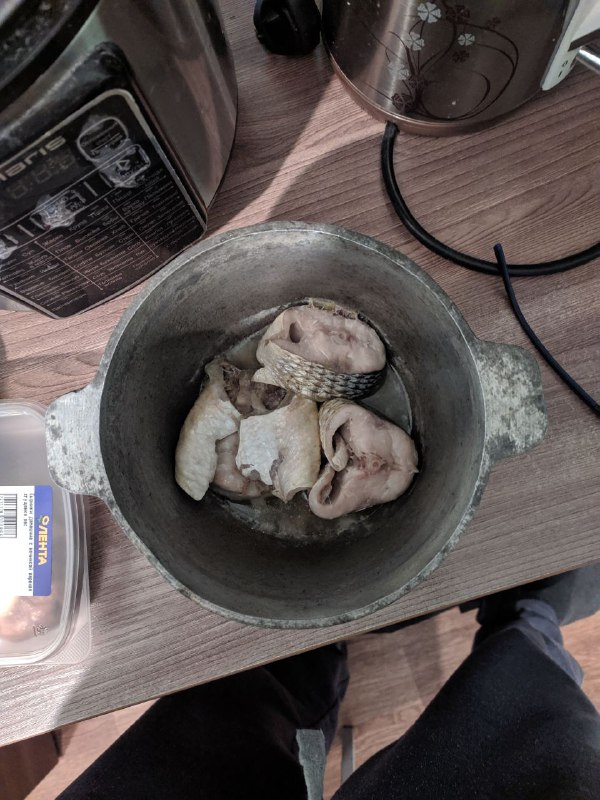

In [85]:
image

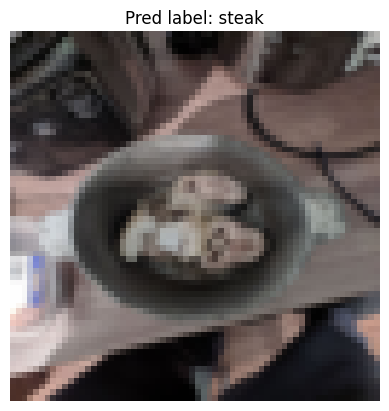

In [84]:
model_4.eval()
with torch.no_grad():
  img = transforms.ToTensor()(image).to(device_gpu)
  resize = transforms.Resize((64, 64))
  img = resize(img).to(device_gpu)
  batch = img.unsqueeze(0).to(device)
  y_pred_logit = model_4(batch)
  pred_label = torch.argmax(y_pred_logit, dim=1)


plt.imshow(img.cpu().permute(1, 2, 0))
plt.title(f"Pred label: {class_names[pred_label]}")
plt.axis(False);